# Problem 2

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
from torch.autograd import Variable
from tqdm import tqdm

# defining the colormap
cmap = plt.cm.coolwarm
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

#### Preprocessing the dataset

In [2]:
df = pd.read_csv('bike_sharing.csv') # read in data
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', drop=True, inplace=True) # set datetime index
X = df.drop(columns=['temp', 'hum', 'windspeed']).to_numpy() # create NumPy array
X_train_raw, X_val_raw = train_test_split(X, test_size=0.25, random_state=0) # split train and validation sets
scaler = StandardScaler().fit(X_train_raw) # fit scaler
X_train = scaler.fit_transform(X_train_raw) # rescale train
X_val = scaler.fit_transform(X_val_raw) # rescale test

## Part 1.a

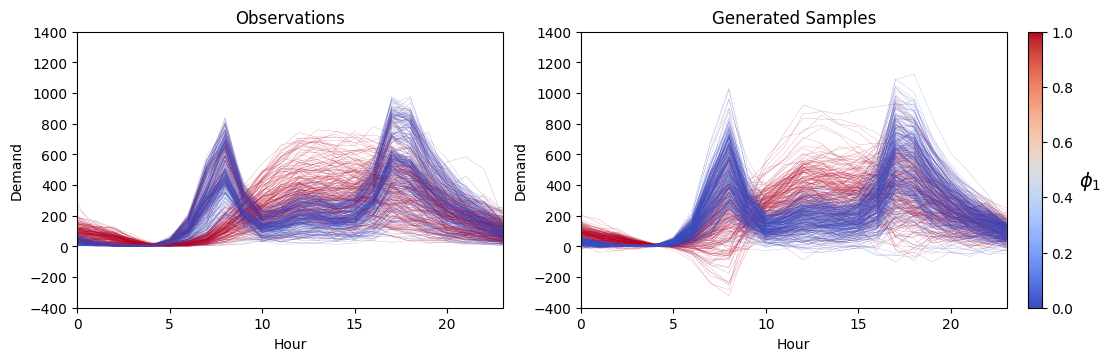

In [3]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(11,3.5),layout='constrained')

# train Gaussian mixture model
GMM = GaussianMixture(n_components=2, random_state=0, covariance_type='full').fit(X_train)

# plot predicted latent variables
for i in range(len(X_train)):
    Z_pred = GMM.predict_proba(X_train[i:i+1])[0,0]
    ax1.plot(X_train_raw[i], linewidth=0.1, color=sm.to_rgba(Z_pred))
ax1.set_xlim([0,23])
ax1.set_ylim([-400,1400])
ax1.set_xlabel('Hour')
ax1.set_ylabel('Demand')
ax1.set_title('Observations')

# plot samples
X_sampled_raw, Z_sampled = GMM.sample(X_train.shape[0]) # sample from Gaussian mixture model
X_sampled = scaler.inverse_transform(X_sampled_raw) # invert standardization
for i in range(len(X_sampled)):
    Z_pred = GMM.predict_proba(X_sampled_raw[i:i+1])[0,0]
    ax2.plot(X_sampled[i], linewidth=0.1, color=sm.to_rgba(Z_pred))

ax2.set_xlim([0,23])
ax2.set_ylim([-400,1400])
ax2.set_xlabel('Hour')
ax2.set_ylabel('Demand')
ax2.set_title('Generated Samples')
cb = fig.colorbar(sm, ax=ax2)
cb.set_label(label=r'$\phi_1$', size=14, rotation=0, ha='left')
plt.show()

## Part 1.b

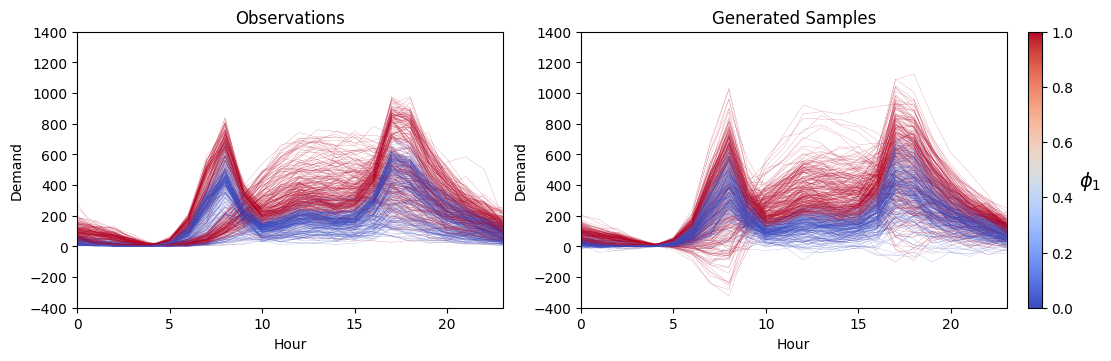

In [5]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(11,3.5),layout='constrained')

# train Gaussian mixture model
GMM_2 = GaussianMixture(n_components=2, random_state=0, covariance_type='spherical').fit(X_train)

# plot predicted latent variables
for i in range(len(X_train)):
    Z_pred = GMM_2.predict_proba(X_train[i:i+1])[0,0]
    ax1.plot(X_train_raw[i], linewidth=0.1, color=sm.to_rgba(Z_pred))
ax1.set_xlim([0,23])
ax1.set_ylim([-400,1400])
ax1.set_xlabel('Hour')
ax1.set_ylabel('Demand')
ax1.set_title('Observations')

# plot samples
X_sampled_raw, Z_sampled = GMM.sample(X_train.shape[0]) # sample from Gaussian mixture model
X_sampled = scaler.inverse_transform(X_sampled_raw) # invert standardization
for i in range(len(X_sampled)):
    Z_pred = GMM_2.predict_proba(X_sampled_raw[i:i+1])[0,0]
    ax2.plot(X_sampled[i], linewidth=0.1, color=sm.to_rgba(Z_pred))

ax2.set_xlim([0,23])
ax2.set_ylim([-400,1400])
ax2.set_xlabel('Hour')
ax2.set_ylabel('Demand')
ax2.set_title('Generated Samples')
cb = fig.colorbar(sm, ax=ax2)
cb.set_label(label=r'$\phi_1$', size=14, rotation=0, ha='left')
plt.show()

## Part 1.c

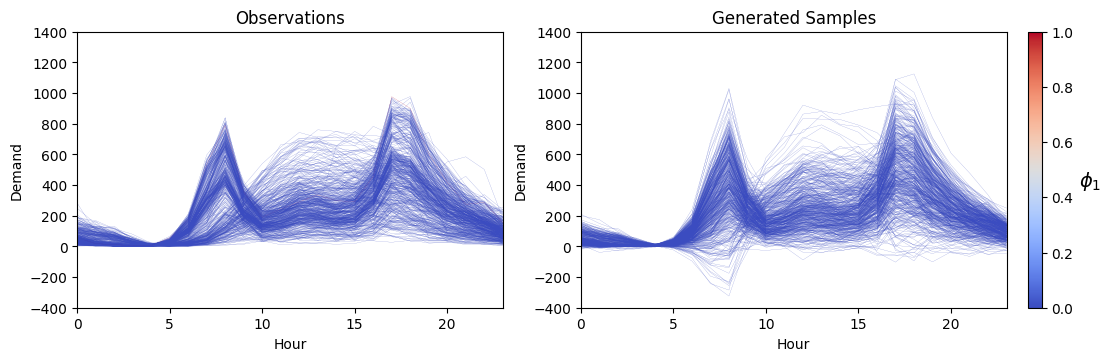

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(11,3.5),layout='constrained')

# train Gaussian mixture model
GMM_3 = GaussianMixture(n_components=400, random_state=0, covariance_type='full').fit(X_train)

# plot predicted latent variables
for i in range(len(X_train)):
    Z_pred = GMM_3.predict_proba(X_train[i:i+1])[0,0]
    ax1.plot(X_train_raw[i], linewidth=0.1, color=sm.to_rgba(Z_pred))
ax1.set_xlim([0,23])
ax1.set_ylim([-400,1400])
ax1.set_xlabel('Hour')
ax1.set_ylabel('Demand')
ax1.set_title('Observations')

# plot samples
X_sampled_raw, Z_sampled = GMM.sample(X_train.shape[0]) # sample from Gaussian mixture model
X_sampled = scaler.inverse_transform(X_sampled_raw) # invert standardization
for i in range(len(X_sampled)):
    Z_pred = GMM_3.predict_proba(X_sampled_raw[i:i+1])[0,0]
    ax2.plot(X_sampled[i], linewidth=0.1, color=sm.to_rgba(Z_pred))

ax2.set_xlim([0,23])
ax2.set_ylim([-400,1400])
ax2.set_xlabel('Hour')
ax2.set_ylabel('Demand')
ax2.set_title('Generated Samples')
cb = fig.colorbar(sm, ax=ax2)
cb.set_label(label=r'$\phi_1$', size=14, rotation=0, ha='left')
plt.show()

## Part 2

In [8]:
class VAE(nn.Module):
    def __init__(self, z_dim):
        super(VAE, self).__init__()
        self.z_dim = z_dim

        self.Encoder = nn.Sequential(nn.Linear(24, 22), nn.Tanh(), 
                                     nn.Linear(22, 20), nn.Tanh(), 
                                     nn.Linear(20, 16), nn.Tanh())
        self.Encoder_mu = nn.Linear(16, self.z_dim)
        self.Encoder_var = nn.Linear(16, self.z_dim)

        self.Decoder = nn.Sequential(nn.Linear(self.z_dim, 16), nn.Tanh(),
                                     nn.Linear(16, 20), nn.Tanh(),
                                     nn.Linear(20, 22), nn.Tanh(), 
                                     nn.Linear(22, 24))

    def encode(self, x):
        x = self.Encoder(x)
        mu, log_var = self.Encoder_mu(x), self.Encoder_var(x)
        eps = Variable(torch.randn(x.shape[0], self.z_dim))
        z = mu + torch.exp(log_var / 2) * eps
        return mu, log_var, z

    def decode(self, z):
        x = self.Decoder(z)
        return x

    def forward(self, x):
        mu, log_var, z = self.encode(x)
        x_ = self.decode(z)
        return mu, log_var, z, x_

In [9]:
X_train, X_val = torch.tensor(X_train).float(), torch.tensor(X_val).float() # construct tensors from data
loss = nn.MSELoss(reduction='sum') # define MSE reconstruction loss
model = VAE(z_dim=2).float() # initialize model with 2-dimensional latent encoding
optimizer = optim.AdamW(model.parameters(), lr=2e-4)
train_loss = []
val_loss = []

for t in (pbar := tqdm(range(10000))):
    optimizer.zero_grad()
    mu, log_var, encoded, decoded = model(X_train) # forward pass
    recon_loss = loss(decoded, X_train) # compute reconstruction loss
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) # compute KL loss
    total_loss = (recon_loss + kl_loss) / X_train.shape[0] # add loss components
    total_loss.backward() # backward pass
    optimizer.step() # optimizer step
    train_loss.append((recon_loss + kl_loss).item())

    # compute validation loss
    with torch.no_grad():
        mu, log_var, encoded, decoded = model(X_val)
        recon_loss = loss(decoded, X_val)
        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        total_loss = (recon_loss + kl_loss) / X_val.shape[0]
        val_loss.append((recon_loss + kl_loss).item())

    # report train and validation loss
    if (t+1)%100 == 0:
        pbar.set_description(f'{np.round(train_loss[-1],3), np.round(val_loss[-1],3)}')

(3370.028, 1138.622): 100%|██████████| 10000/10000 [00:49<00:00, 202.84it/s]


## Part 2.a

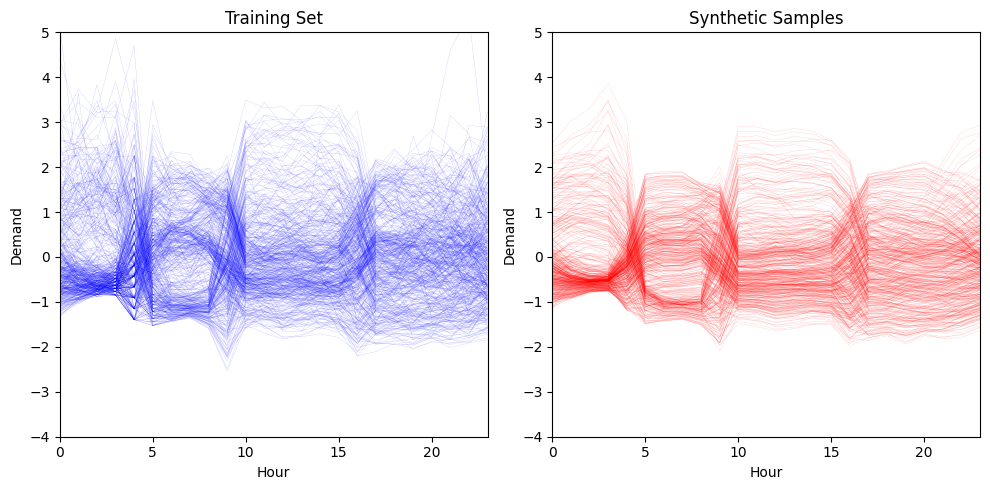

In [12]:
latent_samples = torch.randn(size=(500, 2))

# Decode the latent samples to generate synthetic demand samples
synthetic_samples = model.decode(latent_samples)

# Plot the synthetic samples side-by-side with the training set
plt.figure(figsize=(10, 5))

# Plot training set
plt.subplot(1, 2, 1)
for i in range(len(X_train)):
    plt.plot(X_train[i], linewidth=0.1, color='blue', alpha=0.5)
plt.xlim([0, 23])
plt.ylim([-4, 5])
plt.xlabel('Hour')
plt.ylabel('Demand')
plt.title('Training Set')

# Plot synthetic samples
plt.subplot(1, 2, 2)
for i in range(len(synthetic_samples)):
    plt.plot(synthetic_samples[i].detach().numpy(), linewidth=0.1, color='red', alpha=0.5)
plt.xlim([0, 23])
plt.ylim([-4, 5])
plt.xlabel('Hour')
plt.ylabel('Demand')
plt.title('Synthetic Samples')

plt.tight_layout()
plt.show()

## Part 2.b ##

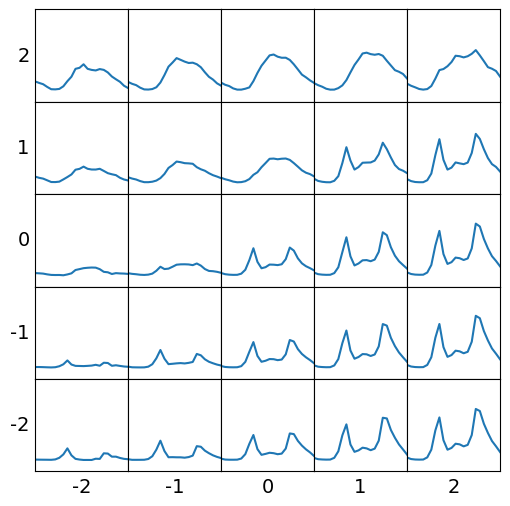

In [13]:
fig, ax = plt.subplots(5,5,figsize=(6,6)) # create grid
with torch.no_grad():
    for i in range(5):
        for j in range(5):
            z = torch.tensor([[2-i,-2+j]]).float() # construct latent encoding z
            ax[i,j].plot(scaler.inverse_transform(model.decode(z).numpy())[0]) # plot decoded z
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            ax[i,j].set_xlim([0,23])
            ax[i,j].set_ylim([-200,1400])
plt.subplots_adjust(wspace=0, hspace=0)
for i in range(5):
    ax[i,0].set_ylabel(2-i, size=14, rotation=0, ha='right', va='center')
for j in range(5):
    ax[4,j].set_xlabel(-2+j, size=14)
plt.show()